_Author: Peter Sadowski_

# Advanced Keras Tutorial
This tutorial introduces:

1) Using the GPU

2) Data generators in Keras.

3) Functional API for complex models.
 


In [1]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
%matplotlib inline

# Tensorflow will grab the memory on all the system gpus unless you tell it not to. 
# Here we tell TF to not use any GPUs.
import os
gpuid = 0 # An index of which gpu to use. 
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES'] = "{}".format(gpuid) # (Empty) List of gpu indices that TF can see.
import tensorflow as tf
CONFIG = tf.ConfigProto(device_count = {'GPU': 1}, log_device_placement=False, allow_soft_placement=False) # Only use a single GPU.
CONFIG.gpu_options.allow_growth = True # Prevents tf from grabbing all gpu memory.
sess = tf.Session(config=CONFIG)
from keras import backend as K
K.set_session(sess)

import theano
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Input, Convolution2D, Flatten, merge
from keras.utils import np_utils
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


## Define data generators for training and validation.

In [2]:
# The following function is used to serve up both train and validation data.
def data_generator(X, Y, batchsize):
    nb_classes = 10
    N = X.shape[0]
    while True:
        indices1 = np.random.randint(low=0, high=N, size=(batchsize,))
        indices2 = np.random.randint(low=0, high=N, size=(batchsize,))
        
        X1 = X[indices1,...].astype('float32') / 255.0
        X2 = X[indices2,...].astype('float32') / 255.0
        Y1 = Y[indices1]
        Y2 = Y[indices2]
        T  = (Y1 + Y2) # Sum of values.
        
        X1 = np.expand_dims(X1, axis=1) # For conv with theano, shape=(batchsize, channels, row, col).
        X2 = np.expand_dims(X2, axis=1) # We are just adding a dummy dimension saying that there is one channel.
        
        Y1 = np_utils.to_categorical(Y1, nb_classes)
        Y2 = np_utils.to_categorical(Y2, nb_classes)
        T  = np_utils.to_categorical(T, 19) # 19 possible values.
        
        yield {'input1':X1 , 'input2':X2},  {'out':T, 'aux1':Y1, 'aux2':Y2}
        
# Load data.
(X_train, Y_train), (X_valid, Y_valid) = mnist.load_data() # Shape = (N,28,28), (N,)
# Create generators.
batchsize  = 200 
data_train = data_generator(X_train, Y_train, batchsize)
data_valid = data_generator(X_valid, Y_valid, batchsize)

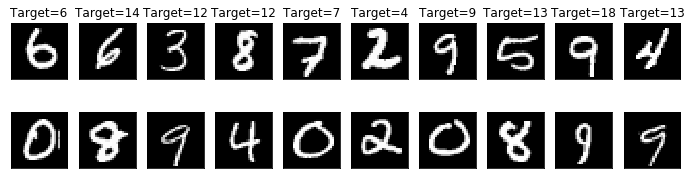

In [5]:
# Plot examples of the data.
inputs, outputs = data_train.__next__()
Xbatch = inputs['input1']
plt.figure(1, figsize=(12,3))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(inputs['input1'][i].reshape(28,28), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.title('Target=%d' % np.argmax(outputs['out'][i]))
    plt.subplot(2,10,10+i+1)
    plt.imshow(inputs['input2'][i].reshape(28,28), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])

# Define Keras Model with the Functional API

Here we define a model that takes two random MNIST images as inputs, and tries to predict the sum of the two numbers. In the model, we can define auxiliary outputs that try to predict the values of each image individually, but the model trains to high accuracy even if we assign zero weight to the auxiliary loss functions.

In [21]:
# Input data.
input1   = Input(shape=(1, 28,28), dtype='float32', name='input1') # Argument 'name' must match name in dictionary.
input2   = Input(shape=(1, 28,28), dtype='float32', name='input2')

# Layer one: Single convolutional layer applied to each input independently, with "shared weights."
nb_filter      = 32     # Number of convolutional kernels.
nb_row, nb_col = 7,7   # Convolution kernel size.
subsample      = (3,3) # Step size for convolution kernels.
conv  = Convolution2D(nb_filter, (nb_row, nb_col), activation='relu', padding='same', strides=subsample)
x1    = conv(input1) # Layer object conv transforms data.
x2    = conv(input2)

# Flatten data: transform from (28,28) to (784,)
x1 = Flatten()(x1)
x2 = Flatten()(x2)

# Layer two: Single fully-connected layer applied to each input independently, with shared weights.
layer = Dense(256, activation='relu')
x1 = layer(x1)
x2 = layer(x2)

# Auxiliary softmax layers try to classify digits. 
# The output of these layers aren't fed into the next layer.
layer = Dense(10) # These weights are shared.
aux1  = Activation(activation='softmax', name='aux1')(layer(x1)) # Output layers must be named.
aux2  = Activation(activation='softmax', name='aux2')(layer(x2))

# Merge hidden representations.
x = keras.layers.concatenate([x1, x2])

# More dense layers then output.
x   = Dense(512, activation='relu')(x)
out = Dense(19, activation='softmax', name='out')(x) # Output layers must be named.

# Create model object that puts it all together.
model = Model(inputs=[input1, input2], outputs=[out, aux1, aux2])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input1 (InputLayer)              (None, 1, 28, 28)     0                                            
____________________________________________________________________________________________________
input2 (InputLayer)              (None, 1, 28, 28)     0                                            
____________________________________________________________________________________________________
conv2d_8 (Conv2D)                (None, 32, 10, 10)    1600        input1[0][0]                     
                                                                   input2[0][0]                     
____________________________________________________________________________________________________
flatten_15 (Flatten)             (None, 3200)          0           conv2d_8[0][0]          

# Optimization

In [22]:
optimizer = Adam(lr=0.001, beta_1=0.99, beta_2=0.999, epsilon=1e-08) # Optimization hyperparameters.

model.compile(optimizer=optimizer,
              loss={'out':'categorical_crossentropy',
                    'aux1':'categorical_crossentropy',
                    'aux2':'categorical_crossentropy'},
              #loss_weights={'out': 1.0, 'aux1': 1.0, 'aux2':1.0}, # These can be tuned.
              loss_weights={'out': 1.0, 'aux1': 0.0, 'aux2':0.0}, # These can be tuned.
              metrics=['accuracy'])


## Train the model.

In [23]:
# Callbacks can be used to stop early, decrease learning rate, checkpoint the model, etc.
#from keras.callbacks import EarlyStopping
#stopping  = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')
callbacks = []#[stopping]

# The fit_generator function loads data batches on the fly, instead of transfering entire data set to the gpu.
history   = model.fit_generator(generator=data_train, steps_per_epoch=100, 
                              epochs=5, verbose=1,
                              callbacks=callbacks, 
                              validation_data=data_valid, validation_steps=100)

Epoch 1/5
100/100 [==============================] - 3s - loss: 2.4033 - out_loss: 2.4033 - aux1_loss: 2.3639 - aux2_loss: 2.3610 - out_acc: 0.1772 - aux1_acc: 0.0735 - aux2_acc: 0.0739 - val_loss: 1.9404 - val_out_loss: 1.9404 - val_aux1_loss: 2.4269 - val_aux2_loss: 2.4338 - val_out_acc: 0.3216 - val_aux1_acc: 0.0947 - val_aux2_acc: 0.0952
Epoch 2/5
100/100 [==============================] - 3s - loss: 1.5034 - out_loss: 1.5034 - aux1_loss: 2.5455 - aux2_loss: 2.5503 - out_acc: 0.4966 - aux1_acc: 0.0684 - aux2_acc: 0.0665 - val_loss: 1.0221 - val_out_loss: 1.0221 - val_aux1_loss: 2.8467 - val_aux2_loss: 2.8505 - val_out_acc: 0.6930 - val_aux1_acc: 0.0608 - val_aux2_acc: 0.0573
Epoch 3/5
100/100 [==============================] - 3s - loss: 0.7202 - out_loss: 0.7202 - aux1_loss: 2.8570 - aux2_loss: 2.8721 - out_acc: 0.7849 - aux1_acc: 0.0930 - aux2_acc: 0.0910 - val_loss: 0.5053 - val_out_loss: 0.5053 - val_aux1_loss: 2.8814 - val_aux2_loss: 2.8745 - val_out_acc: 0.8599 - val_aux1_acc

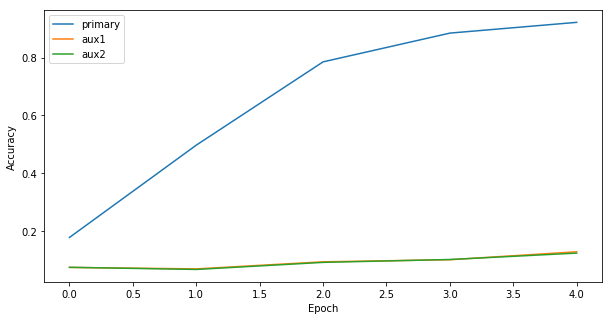

In [24]:
# Plot loss trajectory throughout training.
plt.figure(1, figsize=(10,5))
plt.plot(history.history['out_acc'], label='primary')
plt.plot(history.history['aux1_acc'], label='aux1')
plt.plot(history.history['aux2_acc'], label='aux2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Post-training analysis.

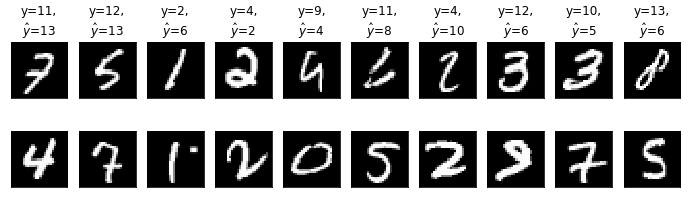

In [30]:
# Plot examples where the predictions were wrong.
inputs, outputs = data_valid.__next__()
plt.figure(1, figsize=(12,3))
i = 0
while i < 10:
    inputs, outputs = data_valid.__next__()
    predictions = model.predict(inputs)
    j = 0
    while j < 100:
        yhat   = predictions[0][j].argmax(axis=-1) # predictions is list: [out, aux1, aux2]
        y      = np.argmax(outputs['out'][j])
        input1 = inputs['input1'][j].reshape(28,28)
        input2 = inputs['input2'][j].reshape(28,28)
        j += 1
        if yhat == y:
            continue
        
        plt.subplot(2,10,i+1)
        plt.imshow(input1, cmap='gray', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])
        plt.title('Pred=%d' % yhat)
        plt.title('y=%d,\n$\hat{y}$=%d' % (y,yhat))
        plt.subplot(2,10,10+i+1)
        plt.imshow(input2, cmap='gray', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])
        i += 1
        if not i<10:
            break
        